# Lesson 3: binned and unbinned fits

## part 1: $\chi^2$ fits

$\chi^2$ describes the agreement between a predictive function $g(x)$ and a set of $n$ measurements $\{(x_i,y_i)\}$ and their uncertainties $\sigma_i$. It is a meausre of the square of the total deviation from $g(x)$:

\begin{align}
\chi^2 = \sum_{i=1}^{n} \bigg[ \frac{y_i - g(x_i)}{\sigma_i}\bigg]^2.
\end{align}

The $\chi^2$ *distribution*, or the $\chi^2$ probability density function, is given by:

\begin{align}
f(\chi^2; n) = \frac{2^{-n/2}}{\Gamma(n/2)} \chi^{n-2}e^{-\chi^2/2}.
\end{align}

If, instead of starting with a set $g(x)$ and calculating $\chi^2$ or the probability, you fit a function with $m$ free parameters, the $\chi^2$ distribution is a function of the number of degrees of freedom $n-m$ (not $n$ as shown above).

When you ask root for ```TMath::Prob(chi2,ndof)```, it's integrating the $\chi^2$ distribution in the range$[\chi^2,\infty]$

Let's start out with a simple example: fit a line with three points (with uncertainties!)

In [1]:
import ROOT
import numpy as np
ROOT.gStyle.SetOptStat(0)
%jsroot

Welcome to JupyROOT 6.18/00


In [2]:
my_canvas = ROOT.TCanvas("c","c",800,600)
f1 = ROOT.TF1("f1","3*x + 2.4",0,10);
my_data = ROOT.TH1D("my_data","my_data",10,0,10)
my_data.Sumw2()
for i in range(0,1000):
    my_data.Fill(f1.GetRandom(),0.001)    

#make the data deliberately a bit worse
f2 = ROOT.TF1("f2","2.*x - 3",0,10);
for i in range(0,100):
    my_data.Fill(f2.GetRandom(),0.1)    

Warning in <TF1::GetRandom>: function:f2 has 15 negative values: abs assumed


Now we have some data, let's try to minimize the $\chi^2$ distribution with a linear function $g(x) = a*x + b$. This is a simple problem that is already solved for us - many times over. You could code up a function to minimise the $\chi^2$ yourself, or just use the inbuilt ROOT functionailty that can fit histograms:

https://root.cern.ch/doc/master/classTH1.html#a7e7d34c91d5ebab4fc9bba3ca47dabdd

This performs a $\chi^2$ fit by default. There are other options listed on the link, some of which we will explore later.

In [3]:
gx = ROOT.TF1("gx","pol1",0,10)
x = my_data.Fit("gx","V")

my_data.Draw()
my_canvas.Draw()


Covariance Matrix:

            	          p0          p1
p0          	    0.001624  -0.0010487
p1          	  -0.0010487  0.00069416

Correlation Matrix:

            	          p0          p1
p0          	           1    -0.98769
p1          	    -0.98769           1

****************************************
Minimizer is Linear
Chi2                      =      15.0601
NDf                       =            8
p0                        =     -0.34808   +/-   0.0402985   
p1                        =     0.259373   +/-   0.026347    


Info in <ROOT::Math::Fitter::DoLeastSquareFit>: use gradient from model function


So we fit a line to our data, but it would be good if we could quantify the results. How good is the fit? 

Usually we say that if $\chi^2/\mbox{nDoF}\sim 1$, the fit is good. Why?

How close does $\chi^2/\mbox{nDoF}$ have to be to one to be considered good? 

How might this change for different numbers of degrees of freedom?

In [4]:
#in principle you should be able to access this from the fit result, but for some reason it is returning a null pointer.
print 'chi squared probability:',ROOT.TMath.Prob(15.0441,8)

chi squared probability: 0.0582936140833


## part 2: the method of maximum likelihood

Now things start to get a bit more complicated.

In the above example, our data was binned (or e.g. two dimensional measurements with associated uncertainties along one variable, which would be more along the lines of what you'd have seen in labs in undergrad).

However, we do not generally want our results to be biased by our (usually arbitrary) choice of binning. 

Instead, we are going to maximize the likelihood function for a given fit function $f$:

\begin{align}
L(x;\theta) = \prod_{i=1}^N f(x_i;\theta).
\end{align}

where $x = (x_1,x_2,...x_N)$ is our set of $N$ measured quantities and $\theta = (\theta_1,\theta_2,..,\theta_m)$ are the set of $m$ parameters of $f$ we would like to estimate (fit).

In this case, the fit functions defined by each $\theta$ we want to test must be normalized (i.e., they need to be probability density functions). Each data point is assigned a probablity of occuring based on $f(x_i;\theta)$. 

Imagine we're fitting data to a gaussian, with test $\theta$ with mean 1 and width 1. If all of our data has $x > 10$, the product of the probabilities (likelihood) is going to be awfully low. But if our data were scattered right around $x \sim 1$, the likelihood will be high.

For some value $\theta = \hat{\theta}$, the likelihood function has its global maximum.

Something important to note is that you'll often come across log-likelihood, rather than likelihood. This is for the simple reason that sums are easier to deal with than products, and:

\begin{align}
-\ln L(x;\theta) = - \sum_{i=1}^N \ln f(x_i;\theta).
\end{align}

The negative sign comes in because when f is less than one, the log will be negative - but $f$ is a probability density function, and thus always less than one. 

Let's do an example (code from https://root.cern.ch/roofit-20-minutes):

In [5]:
# Set up model
# ---------------------
# Declare variables x,mean,sigma with associated name, title, initial
# value and allowed range

#Observable with lower and upper bound
mass = ROOT.RooRealVar("mass", "m_{X}", 5.2, 5.3)

#Fit parameters with starting value, lower bound, and upper bound
mean = ROOT.RooRealVar("mean", "mass of X", 5.28, 5.20,5.30)
sigma = ROOT.RooRealVar("sigma", "width of X", 0.0027,0.001,1.)

# Build Gaussian PDF for our resonance
signalModel = ROOT.RooGaussian("signalModel","signal PDF",mass,mean,sigma)

# Build background p.d.f 
a0 = ROOT.RooRealVar("a0", "a0", 0.5, 0., 1.)
a1 = ROOT.RooRealVar("a1", "a1", -0.2, 0., 1.)
bkg = ROOT.RooChebychev("bkg", "Background", mass, ROOT.RooArgList(a0, a1))

#--- Construct signal+background PDF ---
nsig = ROOT.RooRealVar("nsig","#signal events",200,0.,10000);
nbkg = ROOT.RooRealVar("nbkg","#background events",800,0.,10000)
model = ROOT.RooAddPdf("model","g+a",ROOT.RooArgList(signalModel,bkg),ROOT.RooArgList(nsig,nbkg))


'''
wikipedia fact of the day: In physics, the ARGUS distribution, named after the particle physics experiment ARGUS, 
is the probability distribution of the reconstructed invariant mass of a decayed particle 
candidate in continuum background.
'''

c = ROOT.TCanvas("c", "c", 800, 600)

# Construct plot frame in 'x'
xframe = mass.frame(ROOT.RooFit.Title("resonance search!"))  # RooPlot

#We can now use this p.d.f. to generate an unbinned toy dataset, fit the p.d.f to that dataset using an unbinned maximum likelihood fit
#and visualise the data with the p.d.f overlaid.

# --- Generate a toyMC sample from composite PDF ---
data = model.generate(ROOT.RooArgSet(mass), 2000)

## --- Perform extended ML fit of composite PDF to toy data ---
r = model.fitTo(data)

# --- Plot toy data and composite PDF overlaid ---
data.plotOn(xframe)
model.plotOn(xframe)
ras_bkg = ROOT.RooArgSet(bkg)
model.plotOn(xframe, ROOT.RooFit.Components(ras_bkg), ROOT.RooFit.LineStyle(ROOT.kDashed))

xframe.Draw()

c.Draw()


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (signalModel,bkg)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a0           5.00000e-01  1.00000e-01    0.00000e+00  1.00000e+00
     2 a1           0.00000e+00  1.00000e-01    0.00000e+00  1.00000e+00
 MINUIT WARNING IN PARAM DEF
 ============== STARTING VALUE IS AT LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VA

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [6]:
model.Print("t")
sigma.Print()
mass.Print()

0x6c99570 RooAddPdf::model = 0.808243 [Auto,Dirty] 
  0x6c0b970/V- RooGaussian::signalModel = 4.05757e-25 [Auto,Dirty] 
    0x6b09800/V- RooRealVar::mass = 5.25
    0x6b3da60/V- RooRealVar::mean = 5.27943 +/- 0.000234909
    0x6b3b9a0/V- RooRealVar::sigma = 0.0027765 +/- 0.000217764
  0x6cb4720/V- RooRealVar::nsig = 361.981 +/- 28.9382
  0x6ca0320/V- RooChebychev::bkg = 0.986859 [Auto,Dirty] 
    0x6b09800/V- RooRealVar::mass = 5.25
    0x6c07d10/V- RooRealVar::a0 = 0.541814 +/- 0.0420382
    0x6c14170/V- RooRealVar::a1 = 0.0131409 +/- 0.0401446
  0x6cbd8f0/V- RooRealVar::nbkg = 1637.97 +/- 45.9694
RooRealVar::sigma = 0.0027765 +/- 0.000217764  L(0.001 - 1) 
RooRealVar::mass = 5.25  L(5.2 - 5.3) 


## part 3: fitting histograms with multiple components

i.e. what histfitter and trexfitter do, conceptually.

In this case, you have input histograms or datasets with known shapes, but unknown normalisation. In some control region, you can fit the histograms from each of your background components (e.g. your MC templates), with some floating weight parameter (signal strength, per background you want to allow to float), to maximize the likelihood that they fit the observed data in that control region.

Then, the weight parameter is applied to backgrounds in the *signal region*, under the assumption that any mismodelling is the same in both the signal and control regions.

This can be done with an arbitrary number of backgrounds, and arbitrary number of control/validation/signal regions.

You'll probably use a framework to do this, but it's important to understand what's going on under the hood. We'll setup a simple model in roofit.

In [8]:
# Create model for physics sample
# -------------------------------------------------------------
# Create observables
x = ROOT.RooRealVar("x", "x", -8, 8)
# Construct signal pdf
mean = ROOT.RooRealVar("mean", "mean", 0, -8, 8)
sigma = ROOT.RooRealVar("sigma", "sigma", 0.3, 0.1, 10)
gx = ROOT.RooGaussian("gx", "gx", x, mean, sigma)
# Construct background pdf
a0 = ROOT.RooRealVar("a0", "a0", -0.1, -1, 1)
a1 = ROOT.RooRealVar("a1", "a1", 0.004, -1, 1)
px = ROOT.RooChebychev("px", "px", x, ROOT.RooArgList(a0, a1))

# Construct background pdf
p0 = ROOT.RooRealVar("p0", "p0", 2, -1, 1)
p1 = ROOT.RooRealVar("p1", "p1", 0.004, -1, 1)
p2 = ROOT.RooRealVar("p2", "p2", -0.5, -1, 0)
polx = ROOT.RooPolynomial("px", "px", x, ROOT.RooArgList(a0, a1))

# Construct composite pdf
f = ROOT.RooRealVar("f", "f", 0.2, 0., 1.)
model = ROOT.RooAddPdf(
    "model", "model", ROOT.RooArgList(gx, px), ROOT.RooArgList(f))
# Create model for control sample
# --------------------------------------------------------------
# Construct signal pdf.
# NOTE that sigma is shared with the signal sample model
mean_ctl = ROOT.RooRealVar("mean_ctl", "mean_ctl", -3, -8, 8)
gx_ctl = ROOT.RooGaussian("gx_ctl", "gx_ctl", x, mean_ctl, sigma)
# Construct the background pdf
a0_ctl = ROOT.RooRealVar("a0_ctl", "a0_ctl", -0.1, -1, 1)
a1_ctl = ROOT.RooRealVar("a1_ctl", "a1_ctl", 0.5, -0.1, 1)
px_ctl = ROOT.RooChebychev(
    "px_ctl", "px_ctl", x, ROOT.RooArgList(a0_ctl, a1_ctl))
# Construct the composite model
f_ctl = ROOT.RooRealVar("f_ctl", "f_ctl", 0.5, 0., 1.)
model_ctl = ROOT.RooAddPdf(
    "model_ctl",
    "model_ctl",
    ROOT.RooArgList(
        gx_ctl,
        px_ctl),
    ROOT.RooArgList(f_ctl))
# Generate events for both samples
# ---------------------------------------------------------------
# Generate 1000 events in x and y from model
data = model.generate(ROOT.RooArgSet(x), 100)
data_ctl = model_ctl.generate(ROOT.RooArgSet(x), 2000)
# Create index category and join samples
# ---------------------------------------------------------------------------
# Define category to distinguish physics and control samples events
sample = ROOT.RooCategory("sample", "sample")
sample.defineType("signal")
sample.defineType("control")
# Construct combined dataset in (x,sample)
combData = ROOT.RooDataSet(
    "combData",
    "combined data",
    ROOT.RooArgSet(x),
    ROOT.RooFit.Index(sample),
    ROOT.RooFit.Import(
        "signal",
        data),
    ROOT.RooFit.Import(
        "control",
        data_ctl))
# Construct a simultaneous pdf in (x, sample)
# -----------------------------------------------------------------------------------
# Construct a simultaneous pdf using category sample as index
simPdf = ROOT.RooSimultaneous("simPdf", "simultaneous pdf", sample)
# Associate model with the physics state and model_ctl with the control
# state
simPdf.addPdf(model, "physics")
simPdf.addPdf(model_ctl, "control")
# Perform a simultaneous fit
# ---------------------------------------------------
# Perform simultaneous fit of model to data and model_ctl to data_ctl
simPdf.fitTo(combData)
# Plot model slices on data slices
# ----------------------------------------------------------------
# Make a frame for the physics sample
frame1 = x.frame(ROOT.RooFit.Bins(30), ROOT.RooFit.Title("Physics sample"))
# Plot all data tagged as physics sample
combData.plotOn(frame1, ROOT.RooFit.Cut("sample==sample::physics"))
# Plot "physics" slice of simultaneous pdf.
# NB: You *must* project the sample index category with data using ProjWData
# as a RooSimultaneous makes no prediction on the shape in the index category
# and can thus not be integrated
# NB2: The sampleSet *must* be named. It will not work to pass this as a temporary
# because python will delete it. The same holds for fitTo() and plotOn() below.
sampleSet = ROOT.RooArgSet(sample)
simPdf.plotOn(frame1, ROOT.RooFit.Slice(sample, "signal"), ROOT.RooFit.Components(
    "px"), ROOT.RooFit.ProjWData(sampleSet, combData), ROOT.RooFit.LineStyle(ROOT.kDashed))
# The same plot for the control sample slice
frame2 = x.frame(ROOT.RooFit.Bins(30), ROOT.RooFit.Title("Control sample"))
combData.plotOn(frame2, ROOT.RooFit.Cut("sample==sample::control"))
simPdf.plotOn(frame2, ROOT.RooFit.Slice(sample, "control"),
                ROOT.RooFit.ProjWData(sampleSet, combData))
simPdf.plotOn(frame2, ROOT.RooFit.Slice(sample, "control"), ROOT.RooFit.Components(
    "px_ctl"), ROOT.RooFit.ProjWData(sampleSet, combData), ROOT.RooFit.LineStyle(ROOT.kDashed))
c = ROOT.TCanvas("simultaneous_fit",
                 "simultaneous fit", 800, 400)
c.Divide(2)
c.cd(1)
ROOT.gPad.SetLeftMargin(0.15)
frame1.GetYaxis().SetTitleOffset(1.4)
frame1.Draw()
c.cd(2)
ROOT.gPad.SetLeftMargin(0.15)
frame2.GetYaxis().SetTitleOffset(1.4)
frame2.Draw()
c.Draw()

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
RooAbsTestStatistic::initSimMode: creating slave calculator #0 for state physics (100 dataset entries)
RooAbsTestStatistic::initSimMode: creating slave calculator #1 for state control (2000 dataset entries)
[#1] INFO:Fitting -- RooAbsTestStatistic::initSimMode: created 2 slave calculators.
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (gx,px)
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (gx_ctl,px_ctl)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a0          -1.00000e-01  2.00000e-01   -1.00000e+00  1.00000e+00
     2 a0_ctl      -1.00000e-01  2.00000e-01   -1.00000e+00  1.00000e+00
     3 a1           4.00000e-03  2.00000e-01   -1.00000e+00  1.00000e+00
     4 a1_ct

[#0] WARNING:InputArguments -- RooAbsPdf::fitTo(model_cr) WARNING: a likelihood fit is requested of what appears to be weighted data.
       While the estimated values of the parameters will always be calculated taking the weights into account,
       there are multiple ways to estimate the errors of the parameters. You are advised to make an'n       explicit choice for the error calculation:
           - Either provide SumW2Error(true), to calculate a sum-of-weights-corrected HESSE error matrix
             (error will be proportional to the number of events in MC).
           - Or provide SumW2Error(false), to return errors from original HESSE error matrix
             (which will be proportional to the sum of the weights, i.e., a dataset with <sum of weights> events).
       If you want the errors to reflect the information contained in the provided simulation, choose true.
       If you want the errors to reflect the precision you would be able to obtain with an unweighted dataset


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


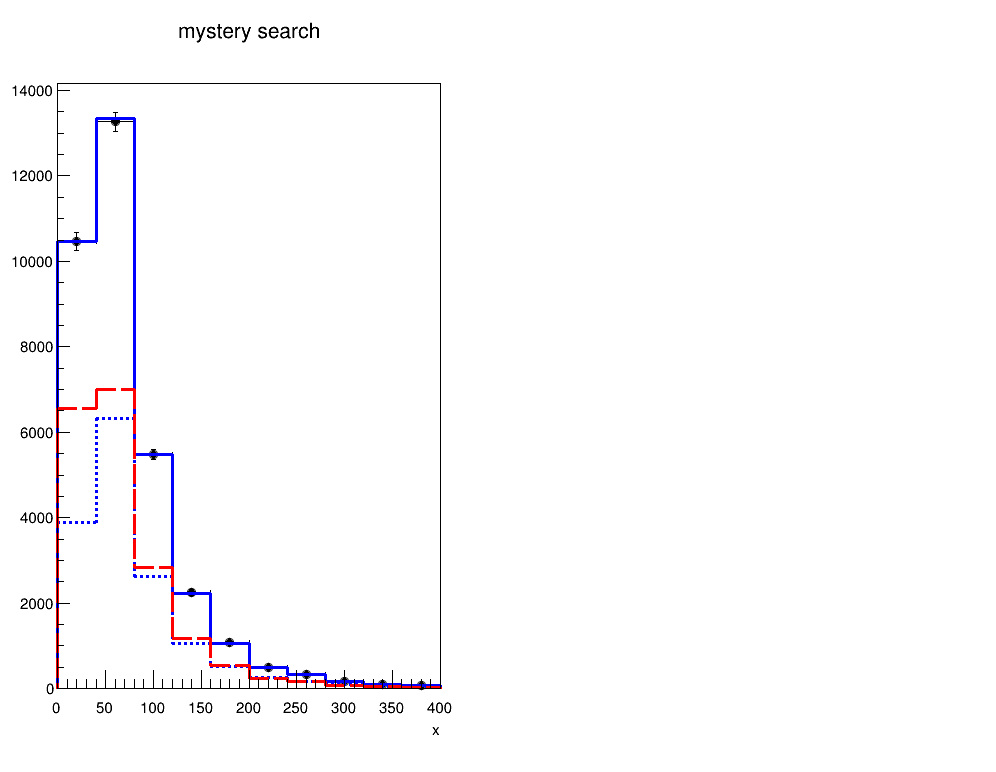

In [8]:
import ROOT 
test_file = ROOT.TFile.Open("test_fitting_hists.root")

x = ROOT.RooRealVar("x","x",0,400)

sig_hist = ROOT.RooDataHist("sig_hist","signal vs x",ROOT.RooArgList(x),test_file.Get("hsig"))
bkg1_sr_hist = ROOT.RooDataHist("bkg1_sr_hist","sr bkg1 vs x",ROOT.RooArgList(x),test_file.Get("htt"))
bkg2_sr_hist = ROOT.RooDataHist("bkg2_sr_hist","sr bkg2 vs x",ROOT.RooArgList(x),test_file.Get("hzg"))

bkg1_cr_hist = ROOT.RooDataHist("bkg1_cr_hist","cr bkg1 vs x",ROOT.RooArgList(x),test_file.Get("htt_cr"))
bkg2_cr_hist = ROOT.RooDataHist("bkg2_cr_hist","cr bkg2 vs x",ROOT.RooArgList(x),test_file.Get("zg_cr"))

data_cr_hist = ROOT.RooDataHist("data_cr_hist","cr data vs x",ROOT.RooArgList(x),test_file.Get("hdata_cr"))
data_sr_hist = ROOT.RooDataHist("data_sr_hist","sr data vs x",ROOT.RooArgList(x),test_file.Get("hdata"))

sig_pdf = ROOT.RooHistPdf("sig_pdf","signal vs x",ROOT.RooArgSet(x),sig_hist)
bkg1_sr_pdf = ROOT.RooHistPdf("bkg1_sr_pdf","sr bkg1 vs x",ROOT.RooArgSet(x),bkg1_sr_hist)
bkg2_sr_pdf = ROOT.RooHistPdf("bkg2_sr_pdf","sr bkg2 vs x",ROOT.RooArgSet(x),bkg2_sr_hist)

bkg1_cr_pdf = ROOT.RooHistPdf("bkg1_cr_pdf","cr bkg1 vs x",ROOT.RooArgSet(x),bkg1_cr_hist)
bkg2_cr_pdf = ROOT.RooHistPdf("bkg2_cr_pdf","cr bkg2 vs x",ROOT.RooArgSet(x),bkg2_cr_hist)

#data_cr_pdf = ROOT.RooHistPdf("data_cr_pdf","cr data vs x",ROOT.RooArgSet(x),data_cr_hist)
#data_sr_pdf = ROOT.RooHistPdf("data_sr_pdf","sr data vs x",ROOT.RooArgSet(x),data_sr_hist)


mu_sig = ROOT.RooRealVar("mu_sig","#signal events",1,0.,2);
mu_bkg1 = ROOT.RooRealVar("mu_bkg1","#background events",1,100.,100000)
mu_bkg2 = ROOT.RooRealVar("mu_bkg2","#background events",1,100.,100000)


model_cr = ROOT.RooAddPdf("model_cr","cr",ROOT.RooArgList(bkg1_cr_pdf,bkg2_cr_pdf),ROOT.RooArgList(mu_bkg1,mu_bkg2))
model = ROOT.RooAddPdf("model","sr",ROOT.RooArgList(bkg1_sr_pdf,bkg2_sr_pdf,sig_pdf),ROOT.RooArgList(mu_bkg1,mu_bkg2,mu_sig))

# Define category to distinguish physics and control samples events
#sample = ROOT.RooCategory("sample", "sample")
#sample.defineType("signal_region")
#sample.defineType("control_region")

model_cr.fitTo(data_cr_hist)

c1 = ROOT.TCanvas("c1", "c1", 1000, 800)
c1.Divide(2)
c1.cd(1)
# Construct plot frame in 'x'
xframe = x.frame(ROOT.RooFit.Title("mystery search"))  # RooPlot

# --- Plot toy data and composite PDF overlaid ---
data_cr_hist.plotOn(xframe)
model_cr.plotOn(xframe)

ras_bkg1 = ROOT.RooArgSet(bkg1_cr_pdf)
model_cr.plotOn(xframe, ROOT.RooFit.Components(ras_bkg1), ROOT.RooFit.LineStyle(ROOT.kDashed))

ras_bkg2 = ROOT.RooArgSet(bkg2_cr_pdf)
model_cr.plotOn(xframe, ROOT.RooFit.Components(ras_bkg2), ROOT.RooFit.LineStyle(9),ROOT.RooFit.LineColor(ROOT.kRed))

xframe.Draw()
c1.Draw()